# Pull Request Features

プルリクエストの特徴量とバグ混入の有無の関係を調べる。

### バグ混入の有無でプルリクエストの特徴量に差があるかを検定

In [2]:
import pandas as pd
from scipy.stats import chi2_contingency, mannwhitneyu


def get_significance(p):
    if p >= 0.05:
        return " "
    elif p >= 0.01:
        return "*"
    elif p >= 0.001:
        return "**"
    else:
        return "***"


NUMERIC_COLUMNS = (
    "age",
    "#added",
    "#deleted",
    "#commits",
    "#files",
    "#comments",
    "#review_comments",
    "#approvals",
    "#changes_requested",
)
BOOLEAN_COLUMNS = (
    "intra_branch",
    "fix",
    "test",
)

# プルリクエストの特徴量データを読み込む
df = pd.read_csv("data/pull_request_features.csv")
df = df[df["bot"] == False]
df = df[df["code_change"] == True]

# 不具合混入の有無でデータを分割
buggy_df = df[df["buggy"] == True]
clean_df = df[df["buggy"] == False]

result_df = pd.DataFrame()

# ==============================================
# 数値特徴量に対して Mann-Whitney U検定を実行
# ==============================================
for feature in NUMERIC_COLUMNS:
    buggy_values = buggy_df[feature]
    clean_values = clean_df[feature]

    # Mann-Whitney U検定
    stat, p = mannwhitneyu(buggy_values, clean_values, alternative="two-sided")

    # 結果
    result_df = pd.concat(
        [
            result_df,
            pd.DataFrame(
                data={
                    "test": "Mann-Whitney U",
                    "p_value": p,
                    "effect_size": 1 - (2 * stat) / (len(buggy_values) * len(clean_values)),
                    "significant": get_significance(p),
                },
                index=[feature],
            ),
        ]
    )

# ==============================================
# 真偽値特徴量に対してカイ二乗検定を実行
# ==============================================
for feature in BOOLEAN_COLUMNS:
    # カイ二乗検定
    table = pd.crosstab(df[feature], df["buggy"])
    stat, p, dof, expected = chi2_contingency(table)

    # 結果
    result_df = pd.concat(
        [
            result_df,
            pd.DataFrame(
                data={
                    "test": "Chi-squared",
                    "p_value":  p,
                    "effect_size": stat / df.shape[0],
                    "significant": get_significance(p),
                },
                index=[feature],
            ),
        ]
    )

# 結果を表示
print(result_df)

                              test       p_value  effect_size significant
age                 Mann-Whitney U  4.973147e-05    -0.086852         ***
#added              Mann-Whitney U  1.113656e-85    -0.419908         ***
#deleted            Mann-Whitney U  6.173618e-56    -0.336935         ***
#commits            Mann-Whitney U  1.285860e-48    -0.276456         ***
#files              Mann-Whitney U  1.636877e-72    -0.382030         ***
#comments           Mann-Whitney U  4.946317e-04    -0.072177         ***
#review_comments    Mann-Whitney U  3.968929e-09    -0.072775         ***
#approvals          Mann-Whitney U  2.629445e-04     0.053997         ***
#changes_requested  Mann-Whitney U  6.261092e-04    -0.020918         ***
intra_branch           Chi-squared  7.008487e-01     0.000030            
fix                    Chi-squared  3.449269e-09     0.007080         ***
test                   Chi-squared  6.427316e-15     0.012323         ***


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, mannwhitneyu
def get_significance(p):
    if p >= 0.05:
        return " "
    elif p >= 0.01:
        return "*"
    elif p >= 0.001:
        return "**"
    else:
        return "***"
df = pd.read_csv("data/pull_request_features.csv")
df = df[df["bot"] == False]
df = df[df["code_change"] == True]
df["use_approvals"] = df["#approvals"] > 0
df["use_comments"] = df["#comments"] > 0
df["use_review_comments"] = df["#review_comments"] > 0
df["use_changes_requested"] = df["#changes_requested"] > 0
for col in ["use_approvals", "use_comments", "use_review_comments", "use_changes_requested", "fix", "test"]:
    table = pd.crosstab(df[col], df["buggy"])
    stat, p, dof, expected = chi2_contingency(table)
    display(table)
    print(f"{col} buggy ratio: {table.loc[True, True] / table.loc[True].sum():.3f}")
    print(f"non {col} buggy ratio: {table.loc[False, True] / table.loc[False].sum():.3f}")
    print(f"{col}: p-value={p}, significance={get_significance(p)}, Cramer's V={((stat / df.shape[0]) ** 0.5):.3f}")

buggy,False,True
use_approvals,,
False,3208,754
True,836,133


use_approvals buggy ratio: 0.137
non use_approvals buggy ratio: 0.190
use_approvals: p-value=0.0001403769701912676, significance=***, Cramer's V=0.054


buggy,False,True
use_comments,,
False,3155,636
True,889,251


use_comments buggy ratio: 0.220
non use_comments buggy ratio: 0.168
use_comments: p-value=6.451648604834704e-05, significance=***, Cramer's V=0.057


buggy,False,True
use_review_comments,,
False,3583,724
True,461,163


use_review_comments buggy ratio: 0.261
non use_review_comments buggy ratio: 0.168
use_review_comments: p-value=2.0910703247287695e-08, significance=***, Cramer's V=0.080


buggy,False,True
use_changes_requested,,
False,3946,847
True,98,40


use_changes_requested buggy ratio: 0.290
non use_changes_requested buggy ratio: 0.177
use_changes_requested: p-value=0.0009696660932317059, significance=***, Cramer's V=0.047


buggy,False,True
fix,,
False,2836,531
True,1208,356


fix buggy ratio: 0.228
non fix buggy ratio: 0.158
fix: p-value=3.4492694647636394e-09, significance=***, Cramer's V=0.084


buggy,False,True
test,,
False,2004,311
True,2040,576


test buggy ratio: 0.220
non test buggy ratio: 0.134
test: p-value=6.427315531685974e-15, significance=***, Cramer's V=0.111


### 機械学習モデルを使用して，予測精度と特徴量重要度を算出

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
\begin{tabular}{lrr}
\toprule
model & R.F. & G.B. \\
\midrule
accuracy & 0.75 & 0.82 \\
precision & 0.22 & 0.49 \\
recall & 0.15 & 0.03 \\
f1 & 0.17 & 0.06 \\
auc & 0.58 & 0.63 \\
mcc & 0.04 & 0.09 \\
f1\_optimal & 0.33 & 0.36 \\
mcc\_optimal & 0.11 & 0.18 \\
\bottomrule
\end{tabular}

roc_auc


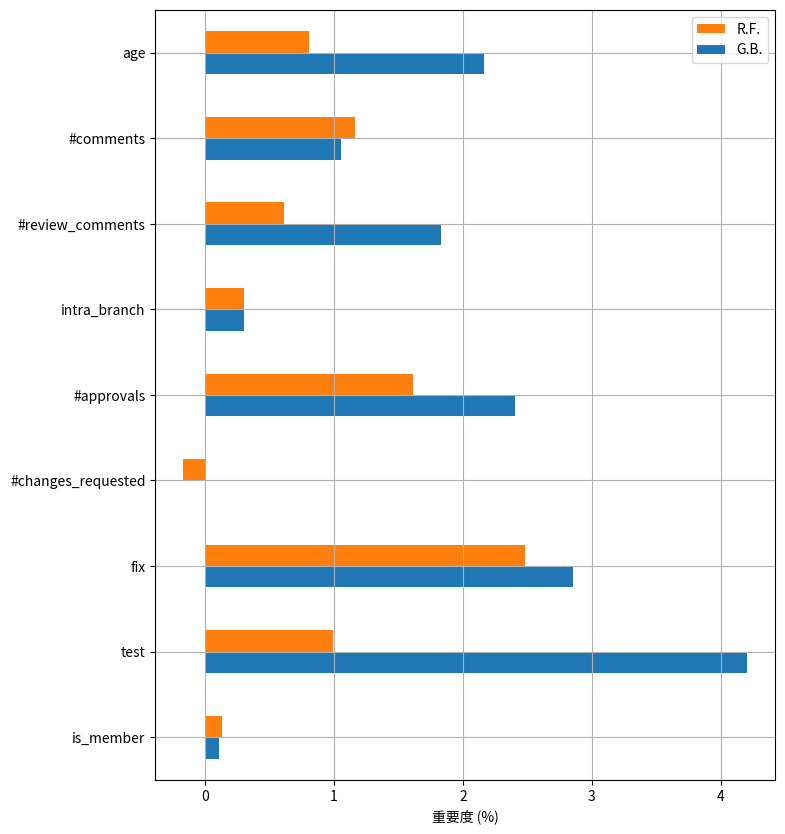

\begin{tabular}{lrr}
\toprule
model & R.F. & G.B. \\
\midrule
age & 0.81 & 2.16 \\
\#comments & 1.16 & 1.05 \\
\#review\_comments & 0.61 & 1.83 \\
intra\_branch & 0.30 & 0.30 \\
\#approvals & 1.62 & 2.41 \\
\#changes\_requested & -0.17 & 0.00 \\
fix & 2.48 & 2.85 \\
test & 0.99 & 4.20 \\
is\_member & 0.13 & 0.11 \\
\bottomrule
\end{tabular}



In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    PrecisionRecallDisplay
)
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

EXCLUDE_COLUMNS = ["project", "id", "url", "bot", "code_change", "#added", "#deleted", "#files", "#commits"]
SCORINGS = (
    # "f1", 
    "roc_auc", 
    # "matthews_corrcoef"
)

# プルリクエストの特徴量データを読み込み
df = pd.read_csv("data/pull_request_features.csv")
df = df[df["bot"] == False]
df = df[df["code_change"] == True]
df = df.drop(EXCLUDE_COLUMNS, axis=1)
X, y = df.drop("buggy", axis=1), df["buggy"]

# データを標準化
X = (X - X.mean()) / X.std()

# モデルの設定
models = {
    # "L.R.": LogisticRegression(),
    # "D.T.": DecisionTreeClassifier(random_state=0),
    "R.F.": RandomForestClassifier(class_weight="balanced", random_state=0),
    # "A.B.": AdaBoostClassifier(random_state=0),
    "G.B.": GradientBoostingClassifier(random_state=0),
    # "XGB": xgb.XGBClassifier(),
}

# クロスバリデーションの設定
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# 特徴量の重要度を保持するデータフレーム
importance_df_dict = {scoring: pd.DataFrame() for scoring in SCORINGS}

# モデルの精度を保持するデータフレーム
scores_df = pd.DataFrame()



for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    print(f"Fold {i+1}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    for model_name, model in models.items():
        # モデルの学習
        model.fit(X_train, y_train)

        # 予測確率を取得 (閾値調整のため)
        y_scores = model.predict_proba(X_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
        # F1スコアを計算 (最後の要素はprecision=1, recall=0なので除外することがある)
        f1_scores = 2 * recall * precision / (recall + precision + 1e-10) # ゼロ除算を回避
        
        # F1が最大になるインデックスを取得し、対応する閾値を選ぶ
        # thresholdsの配列長はprecision/recallより1短いため調整
        optimal_idx = np.argmax(f1_scores[:-1]) 
        optimal_threshold = thresholds[optimal_idx]

        # --- 3. 最適閾値で再評価 ---
        y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

        # モデルの精度の計算 (Accuracy, Precision, Recall, F1-Score, AUC, MCC)
        y_pred = model.predict(X_test)
        row = {
            "model": model_name,
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "auc": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            "mcc": matthews_corrcoef(y_test, y_pred),
            "f1_optimal": f1_score(y_test, y_pred_optimal),
            "mcc_optimal": matthews_corrcoef(y_test, y_pred_optimal),
        }



        scores_df = pd.concat(
            [
                scores_df,
                pd.DataFrame([row]),
            ],
            ignore_index=True,
        )
        for scoring in importance_df_dict.keys():
            # 特徴量の重要度の算出
            result = permutation_importance(
                model,
                X_test,
                y_test,
                n_repeats=10,
                random_state=0,
                scoring=scoring,
            )

            # 結果の保存
            row_df = pd.DataFrame(
                [
                    {
                        "model": model_name,
                    }
                    | {
                        feature: result.importances_mean[i]
                        for i, feature in enumerate(X_test.columns)
                    }
                ]
            )
            importance_df_dict[scoring] = pd.concat(
                [
                    importance_df_dict[scoring],
                    row_df,
                ],
                ignore_index=True,
            )

        # print(f"{model_name=}")
        # display(pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False))

# ==============================
# 結果の可視化
# ==============================

# 精度の平均値
scores_df = scores_df.groupby("model").mean()
print(scores_df.T[models.keys()].to_latex(float_format="%.2f", escape=True))

plt.rc("font", family="Noto Sans CJK JP")
# 特徴量の重要度の平均値
for scoring, importance_df in importance_df_dict.items():
    importance_df = importance_df.groupby("model").mean() * 100
    importance_df = importance_df.T[models.keys()]

    # 描画
    ax = importance_df.iloc[::-1, ::-1].plot.barh(figsize=(8, 10))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    plt.grid()
    plt.xlabel("重要度 (%)")
    print(scoring)
    plt.show()
    print(importance_df.to_latex(float_format="%.2f", escape=True))

### ロジスティック回帰分析

In [ ]:
import numpy as np
import polars as pl
import statsmodels.api as sm

EXCLUDE_COLUMNS = ["project", "id", "url", "bot", "code_change"]

# プルリクエストの特徴量データを読み込み
df = (
    pl.read_csv("data/pull_request_features.csv")
    .filter(pl.col("bot") == False)
    .filter(pl.col("code_change") == True)
    .drop(EXCLUDE_COLUMNS)
)

# ロジスティック回帰分析
X = df.drop("buggy").to_pandas()
X = sm.add_constant(X)
y = df["buggy"].to_numpy()
model = sm.Logit(y, X.astype(float))
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.448142
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4931
Model:                          Logit   Df Residuals:                     4918
Method:                           MLE   Df Model:                           12
Date:                Sat, 01 Feb 2025   Pseudo R-squ.:                 0.04896
Time:                        17:11:18   Log-Likelihood:                -2209.8
converged:                       True   LL-Null:                       -2323.6
Covariance Type:            nonrobust   LLR p-value:                 6.455e-42
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.1278      0.076    -28.024      0.000      -2.277      -1.979
age  

## SHAP

model_name='R.F.'


<Figure size 640x480 with 0 Axes>

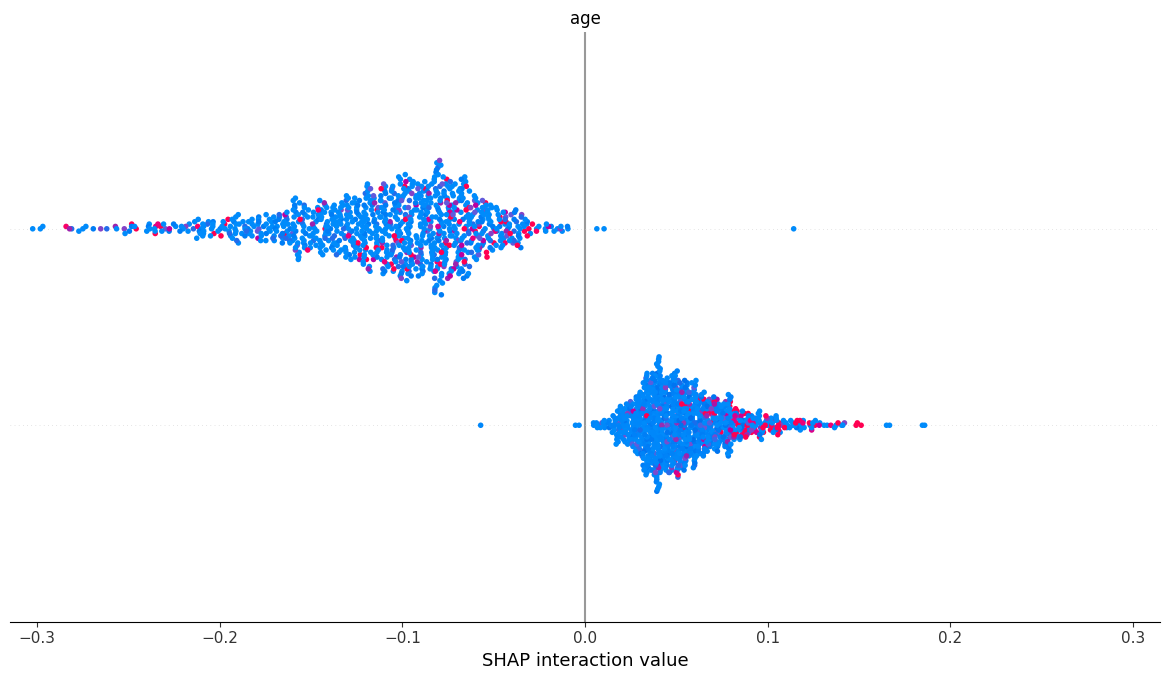

<Figure size 640x480 with 0 Axes>

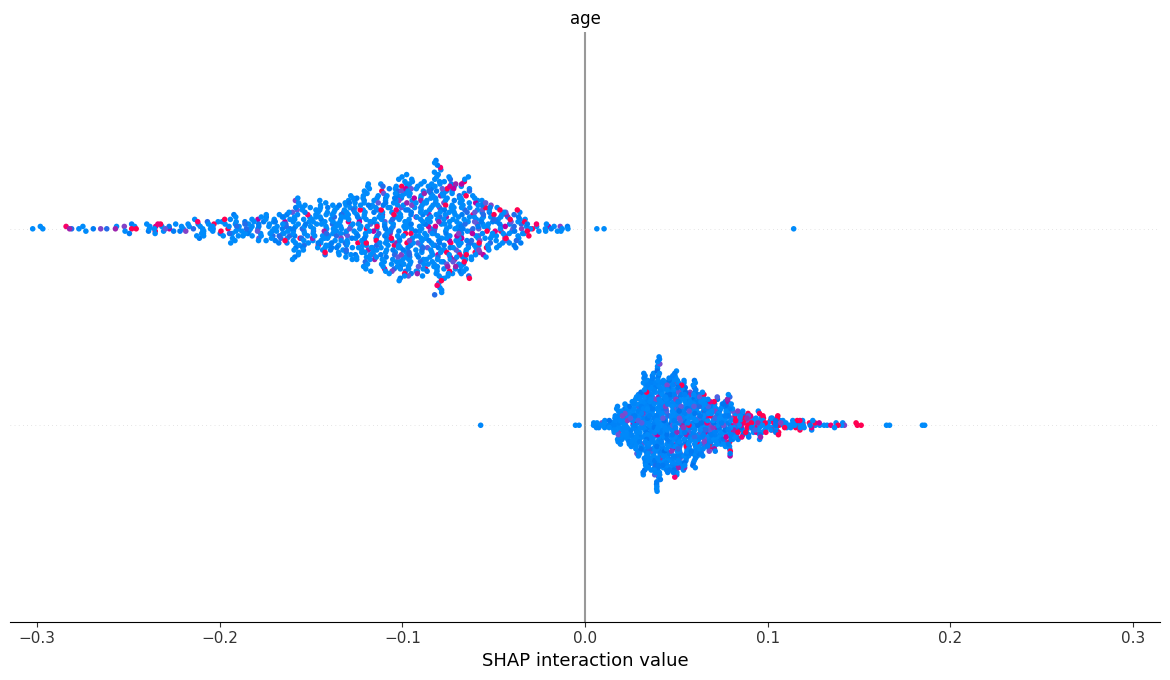

model_name='G.B.'


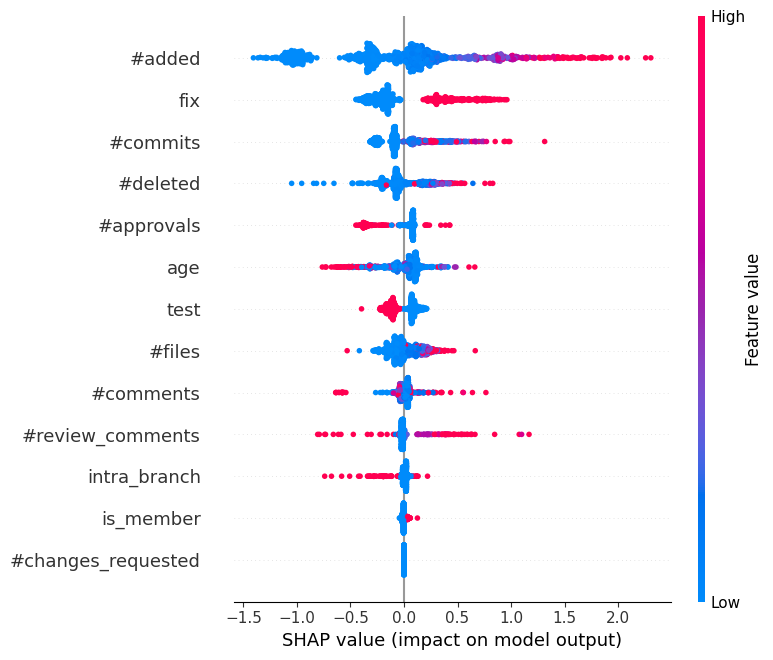

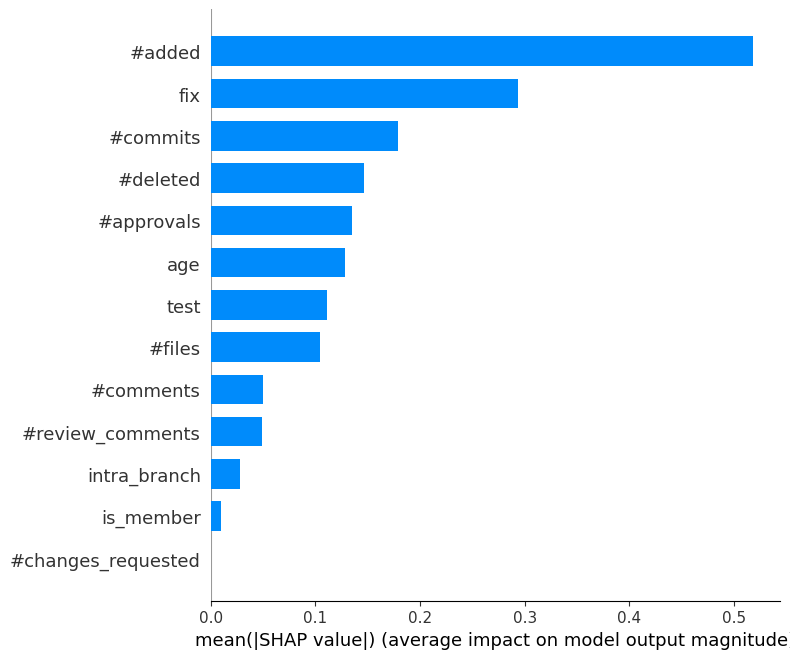

In [1]:
# SHAPによる特徴量の重要度
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.model_selection import train_test_split
import shap

EXCLUDE_COLUMNS = ["project", "id", "url", "bot", "code_change"]

# プルリクエストの特徴量データを読み込み
df = pd.read_csv("data/pull_request_features.csv")
df = df[df["bot"] == False]
df = df[df["code_change"] == True]
df = df.drop(EXCLUDE_COLUMNS, axis=1)
X, y = df.drop("buggy", axis=1), df["buggy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# データを標準化
X = (X - X.mean()) / X.std()

# モデルの設定
models = {
    # "R.F.": RandomForestClassifier(class_weight="balanced", random_state=0),
    "G.B.": GradientBoostingClassifier(random_state=0),
}

for model_name, model in models.items():
    print(f"{model_name=}")

    model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=True)
    plt.show()

    shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
    plt.show()



### 追加行数とコメント数の相関

Pearson correlation: 0.2017635162153347, p-value: 1.8444675592103402e-46


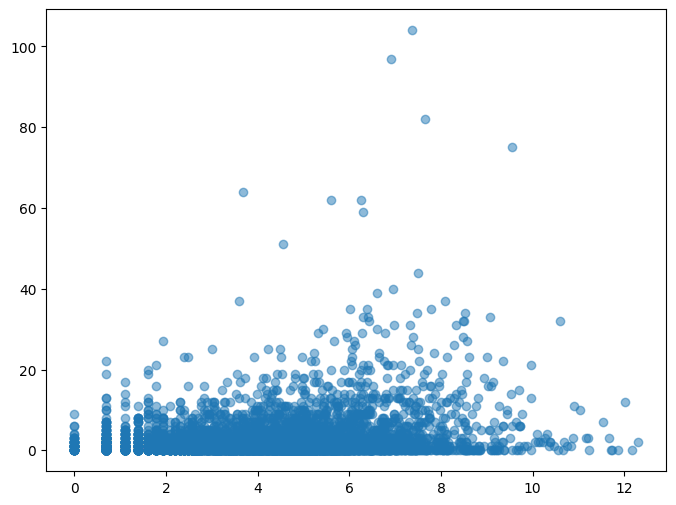

In [ ]:
# 追加行数とコメント数の相関
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

df = pd.read_csv("data/pull_request_features.csv")
df = df[df["bot"] == False]
df = df[df["code_change"] == True]
df["log_#added"] = np.log1p(df["#added"])

plt.figure(figsize=(8, 6))
plt.scatter(df["log_#added"], df["#comments"], alpha=0.5)


stat, p = stats.pearsonr(df["log_#added"], df["#comments"])
print(f"Pearson correlation: {stat}, p-value: {p}")




In [3]:
import pandas as pd

df  = pd.read_csv("data/pull_request_features.csv")
# is_memberの数と割合
print(df.groupby("project").agg({
    "is_member": ["count", "mean"]
})
.agg({
    ("is_member", "count"): "sum",
    ("is_member", "mean"): "mean"
}))
print(df["is_member"].mean())

(is_member, count)    6409.000000
(is_member, mean)        0.285762
dtype: float64
0.2429396161647683


In [12]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

df = pd.read_csv("data/pull_request_features.csv")
df = df[df["bot"] == False]
df = df[df["code_change"] == True]
df = df[(200 < df["#added"]) & (df["#added"] < 300)]

stat, p = mannwhitneyu(df[df["buggy"] == True]["#approvals"], df[df["buggy"] == False]["#approvals"])
print(f"Mann-Whitney U test: stat={stat}, p-value={p}, len(buggy)={len(df[df['buggy'] == True])}, len(clean)={len(df[df['buggy'] == False])}")

Mann-Whitney U test: stat=7263.5, p-value=0.014884256045201265, len(buggy)=71, len(clean)=237
